In [1]:
from colorcloud.biasutti2019riu import SemanticSegmentationTask, RIUNet
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
import lightning as L
from torchvision.transforms import v2
import wandb
import time
from lightning.pytorch.loggers import WandbLogger
from datetime import datetime
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchmetrics.classification import Accuracy
from torchmetrics.segmentation import MeanIoU
from torchmetrics.classification import Dice
from torchmetrics.classification import MulticlassF1Score
from colorcloud.behley2019iccv import SemanticKITTIDataset, SphericalProjection
from colorcloud.behley2019iccv import ProjectionTransform, ProjectionToTensorTransform, SemanticSegmentationLDM
from colorcloud.behley2019iccv import ProjectionVizTransform
from PIL import Image
import os

# Visualization

In [2]:
data_path = '../../data'
train_dataset = SemanticKITTIDataset(data_path=data_path, split='train')
val_dataset = SemanticKITTIDataset(data_path=data_path, split='valid')
test_dataset = SemanticKITTIDataset(data_path=data_path, split='test')

In [3]:
def plot_projections(img, label):
    fig, axs = plt.subplots(6, 1, figsize=(20,10), layout='compressed')
    for i, (ax, title) in enumerate(zip(axs, ['x', 'y', 'z', 'r', 'd', 'label'])):
        if i < 5:
            ax.imshow(img[:,:,i])
        else:
            ax.imshow(label)
        ax.set_title(title)
        ax.axis('off')

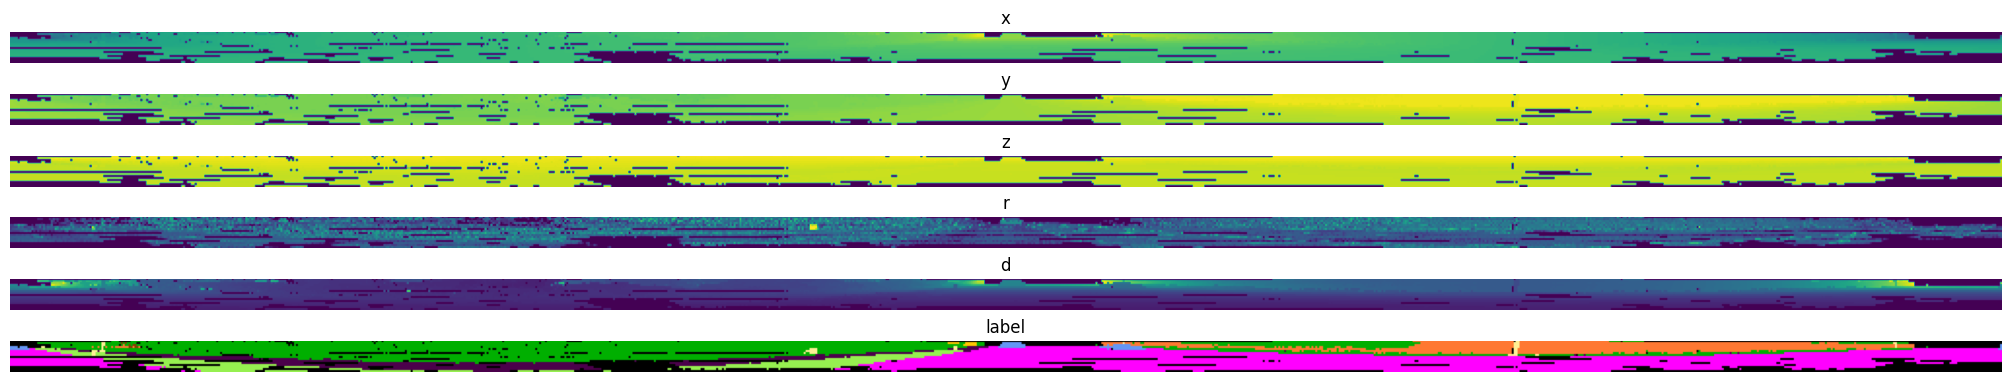

In [4]:
proj = SphericalProjection(fov_up_deg=3., fov_down_deg=-25., W=1024, H=64)
scaling_values = {
    "x" : {"min": -100., "max":100.},
    "y" : {"min": -100., "max":100.},
    "z" : {"min": -31., "max":5.},
    "r" : {"min": 0., "max":1.},
    "d" : {"min": 0., "max":100.}
}
tfms = v2.Compose([
    ProjectionTransform(proj),
    ProjectionVizTransform(val_dataset.color_map_rgb_np, val_dataset.learning_map_inv_np, scaling_values),
])
index = list(range(0, 64, 4))
test_dataset.set_transform(tfms)
item = test_dataset[100]
img = item['frame'][index,:,:]
label = item['label'][index,:,:]

plot_projections(img, label)

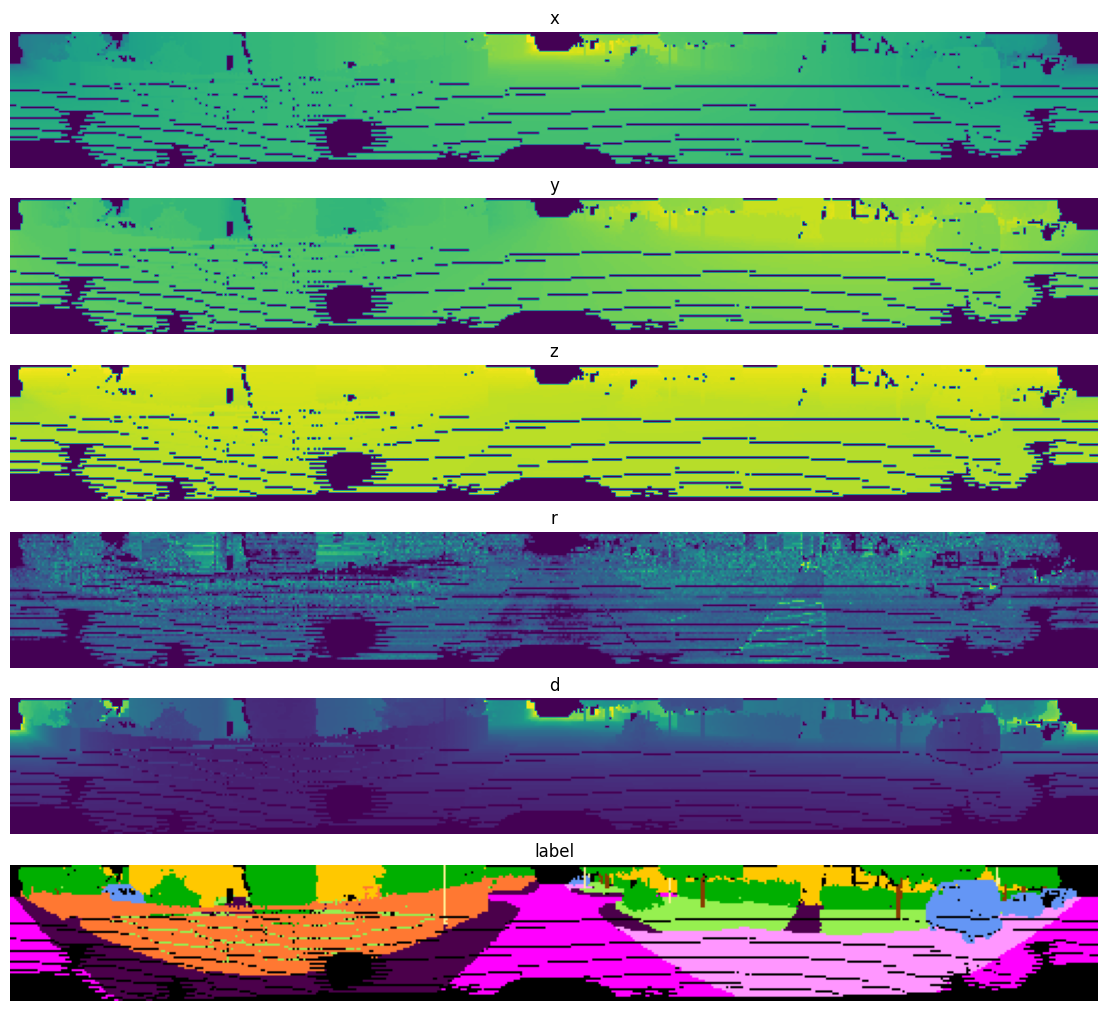

In [5]:
proj = SphericalProjection(fov_up_deg=3., fov_down_deg=-25., W=512, H=64)
scaling_values = {
    "x" : {"min": -100., "max":100.},
    "y" : {"min": -100., "max":100.},
    "z" : {"min": -31., "max":5.},
    "r" : {"min": 0., "max":1.},
    "d" : {"min": 0., "max":100.}
}
tfms = v2.Compose([
    ProjectionTransform(proj),
    ProjectionVizTransform(val_dataset.color_map_rgb_np, val_dataset.learning_map_inv_np, scaling_values),
])

train_dataset.set_transform(tfms)
item = train_dataset[100]
img = item['frame']
label = item['label']

plot_projections(img, label)

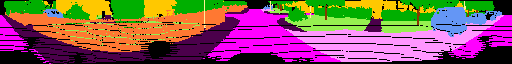

In [6]:
from PIL import Image

# index = list(range(0, 64, 4))
# label = item['label'][index,:,:]

label = item['label']
label = label.astype(np.uint8)
pil_image = Image.fromarray(label)
pil_image.save("64x512.png")
pil_image.show()

# Training

In [7]:
proj = SphericalProjection(fov_up_deg=4., fov_down_deg=-26., W=1024, H=64)
tfms = v2.Compose([
    ProjectionTransform(proj),
    ProjectionToTensorTransform(),
])

data_path = '../../data'
train_dataset = SemanticKITTIDataset(data_path=data_path, split='train', transform=tfms)
val_dataset = SemanticKITTIDataset(data_path=data_path, split='valid', transform=tfms)
test_dataset = SemanticKITTIDataset(data_path=data_path, split='test', transform=tfms)

print("Size of train dataset: ", len(train_dataset))
print("Size of val dataset: ", len(val_dataset))
print("Size of test dataset: ", len(test_dataset))

Size of train dataset:  2761
Size of val dataset:  1101
Size of test dataset:  271


In [8]:
train_dataset[0]["frame"].shape, train_dataset[0]["label"].shape, train_dataset[0]["mask"].shape

(torch.Size([5, 64, 1024]), torch.Size([64, 1024]), torch.Size([64, 1024]))

Contanto a quantidade de pontos de cada label

In [9]:
from collections import defaultdict
class_counts = defaultdict(int)

for item in tqdm(train_dataset):
    unique, counts = np.unique(np.array(item["label"]), return_counts=True)
    for u, c in zip(unique, counts):
        if u != -1:
            class_counts[u] += c 

100%|██████████| 2761/2761 [01:18<00:00, 34.99it/s]


In [10]:
class_counts = dict(class_counts)
class_counts

{0: 4309386,
 1: 4405037,
 4: 299803,
 5: 352476,
 6: 52724,
 9: 24413312,
 10: 2359276,
 11: 23762770,
 12: 204492,
 13: 19205669,
 14: 18868019,
 15: 29730618,
 16: 424654,
 17: 7630777,
 18: 331582,
 19: 51845,
 2: 5593,
 3: 4244,
 7: 34901}

Gerando a frequência de cada classe

In [11]:
frequency = {}

total = sum(class_counts.values())
for key, value in class_counts.items():
    frequency[key] = class_counts[key]/total

frequency = dict(sorted(frequency.items(), key=lambda item: item[0]))
frequency

{0: 0.03158281514623923,
 1: 0.032283826346338945,
 2: 4.099022113890842e-05,
 3: 3.110361139165517e-05,
 4: 0.0021972092379953802,
 5: 0.002583241406429087,
 6: 0.00038640593944713167,
 7: 0.00025578396352030086,
 9: 0.17892134053516298,
 10: 0.017290764342520883,
 11: 0.17415362009172516,
 12: 0.0014986898446518256,
 13: 0.140755340502535,
 14: 0.13828075652836147,
 15: 0.2178910435216183,
 16: 0.0031122226653892394,
 17: 0.055924769657017016,
 18: 0.0024301125524193693,
 19: 0.00037996388609810606}

In [12]:
def calculate_class_weights(frequencies, exponent):
    median_freq = np.median(frequencies)
    class_weights = (median_freq / frequencies) ** exponent
    return torch.tensor(class_weights, dtype=torch.float32)

class_weights = calculate_class_weights(frequencies=list(frequency.values()), exponent=0.5)
class_weights

tensor([ 0.3139,  0.3105,  8.7136, 10.0030,  1.1901,  1.0976,  2.8380,  3.4882,
         0.1319,  0.4243,  0.1337,  1.4411,  0.1487,  0.1500,  0.1195,  1.0000,
         0.2359,  1.1317,  2.8620])

In [13]:
batch_size = 8

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [14]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [15]:
n_epochs = 1

#class_weight = class_weights.to(device)

model = RIUNet(in_channels=5, hidden_channels=(64, 128, 256, 512), n_classes=20).to(device)
#loss_func = torch.nn.CrossEntropyLoss(weight=torch.tensor([ 0.9510,  2.2461, 49.2229,  1.0208,  2.2461,  0.9549]).to(device), reduction='none')
loss_func = torch.nn.CrossEntropyLoss(reduction='none')
#loss_func = RiuNet_loss(device)
opt = AdamW(model.parameters(), lr=5e-4, eps=1e-5)

accuracy = Accuracy(task="multiclass", num_classes=model.n_classes, average=None).to(device)
accuracy_dict = {"train": [], "val": []}

# Mean IoU
miou = MeanIoU(num_classes=model.n_classes, per_class=True).to(device)  # Ajuste aqui
miou_dict = {"train": [], "val": []}

dice = Dice(num_classes=model.n_classes).to(device)
dice_dict = {"train": [], "val": []}

# Multiclass F1 Score
mcf1s = MulticlassF1Score(num_classes=model.n_classes, average=None).to(device)
mcf1s_dict = {"train": [], "val": []}

train_steps = len(train_loader) // batch_size
val_steps = len(val_loader) // batch_size
H = {"train_loss": [], "val_loss": []} # store loss history

In [17]:
start_time = time.time()

for epoch in range(n_epochs):

    model.train()

    total_train_loss = 0
    total_val_loss = 0

    for batch in tqdm(train_loader, desc="Training", leave=True):
        train_item = {key: value.to(device) for key, value in batch.items()}
        img = train_item['frame']
        label = train_item['label']
        mask = train_item['mask']

        #label = label.clone()  # Evita operações in-place
        label[~mask] = 0

        pred = model(img)        
        label = label.long()
        
        #train_loss = loss_func(pred, label, mask)
        train_loss = loss_func(pred, label)
        print(train_loss.shape, train_loss)
        print('\n\nmask: ', mask.shape, mask)
        train_loss = train_loss[mask]
        train_loss = train_loss.mean()

        pred_f = torch.permute(pred, (0, 2, 3, 1)) # N,C,H,W -> N,H,W,C
        pred_f = torch.flatten(pred_f, 0, -2)      # N,H,W,C -> N*H*W,C
        mask_f = torch.flatten(mask)               # N,H,W   -> N*H*W
        pred_m = pred_f[mask_f, :]
        label_m = label[mask]
        current_train_acc = accuracy(pred_m, label_m)
        accuracy_dict["train"].append(current_train_acc.cpu().detach().numpy())

        pred_labels = torch.argmax(pred, dim=1).to(device)

        mask_miou = (label != 0)
        pred_labels[~mask] = 0
        current_train_miou = miou(pred_labels, label)
        miou_dict["train"].append(current_train_miou.cpu().detach().numpy())
        current_train_dice = dice(pred_labels, label)
        dice_dict["train"].append(current_train_dice.cpu().detach().numpy())
        current_train_mcf1s = mcf1s(pred_labels, label)
        mcf1s_dict["train"].append(current_train_mcf1s.cpu().detach().numpy())
        
        opt.zero_grad()
        train_loss.backward()
        opt.step()

        total_train_loss += train_loss

    with torch.no_grad():

        model.eval()

        for batch in tqdm(val_loader, desc="Eval", leave=True):
            val_item = {key: value.to(device) for key, value in batch.items()}
            img = val_item['frame']
            label = val_item['label']
            mask = val_item['mask']
    
            #label = label.clone()  # Evita operações in-place
            label[~mask] = 0
    
            pred = model(img)
            label = label.long()
            #val_loss = loss_func(pred, label, mask)
            val_loss = loss_func(pred, label)
            val_loss = val_loss[mask]
            val_loss = val_loss.mean()

            pred_f = torch.permute(pred, (0, 2, 3, 1)) # N,C,H,W -> N,H,W,C
            pred_f = torch.flatten(pred_f, 0, -2)      # N,H,W,C -> N*H*W,C
            mask_f = torch.flatten(mask)               # N,H,W   -> N*H*W
            pred_m = pred_f[mask_f, :]
            label_m = label[mask]
            current_val_acc = accuracy(pred_m, label_m)
            accuracy_dict["val"].append(current_val_acc.cpu().detach().numpy())

            pred_labels = torch.argmax(pred, dim=1).to(device)
            mask_miou = (label != 0)
            pred_labels[~mask] = 0
            current_val_miou = miou(pred_labels, label)
            miou_dict["val"].append(current_val_miou.cpu().detach().numpy())
            current_val_dice = dice(pred_labels, label)
            dice_dict["val"].append(current_val_dice.cpu().detach().numpy())
            current_val_mcf1s = mcf1s(pred_labels, label)
            mcf1s_dict["val"].append(current_val_mcf1s.cpu().detach().numpy())
        
            total_val_loss += val_loss

    avg_train_loss = total_train_loss / train_steps
    avg_val_loss = total_val_loss / val_steps

    # Store loss history for graphical visualization
    H["train_loss"].append(avg_train_loss.cpu().detach().numpy()) 
    H["val_loss"].append(avg_val_loss.cpu().detach().numpy())

    print("CURRENT EPOCH: {}/{}".format(epoch + 1, n_epochs))
    print("Train loss: {:.10f}, Val loss {:.4f}".format(avg_train_loss, avg_val_loss))

    current_train_miou
    model_name = f"ckpt/semanticKITTI/no_weight_epoch_{epoch}.pt"
    torch.save(model, model_name)

    torch.cuda.empty_cache()  # Opcional: libera cache da GPU após cada época

end_time = time.time()

Training:   0%|          | 0/346 [00:00<?, ?it/s]

torch.Size([8, 64, 1024]) tensor([[[2.9818, 2.9207, 2.8963,  ..., 2.8185, 2.8457, 2.9385],
         [2.9273, 2.8879, 2.8945,  ..., 2.8400, 2.8298, 2.8856],
         [2.8606, 2.8983, 2.8774,  ..., 2.8081, 2.8259, 2.8446],
         ...,
         [2.8631, 2.8111, 2.8338,  ..., 2.8995, 2.8601, 2.8279],
         [2.9080, 2.8378, 2.8212,  ..., 2.8662, 2.8770, 2.8923],
         [2.9472, 2.8695, 2.7976,  ..., 2.8258, 2.8404, 2.8820]],

        [[2.7947, 2.8059, 2.7819,  ..., 2.9030, 2.9233, 2.8264],
         [2.8286, 2.8949, 2.8579,  ..., 2.8961, 2.9084, 2.8451],
         [2.9716, 2.9843, 2.9371,  ..., 2.8931, 2.8977, 2.8821],
         ...,
         [2.7113, 2.7127, 2.7487,  ..., 2.8637, 2.8022, 2.7537],
         [2.7136, 2.7650, 2.8608,  ..., 2.9148, 2.8478, 2.7659],
         [2.7831, 2.8517, 2.8989,  ..., 2.8500, 2.9081, 2.8248]],

        [[2.9820, 2.8953, 2.9300,  ..., 2.8091, 2.8344, 2.9221],
         [2.9086, 2.8923, 2.9050,  ..., 2.8414, 2.8555, 2.8336],
         [2.8435, 2.8075, 2.8521

Training:   0%|          | 0/346 [00:09<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
current_train_acc

In [ ]:
current_train_miou

In [ ]:
model_name = "ckpt/semanticKITTI/x64_10ep_8bs_fulldata_terrain.pt"
torch.save(model, model_name)

# Inference

In [ ]:
proj = SphericalProjection(fov_up_deg=15., fov_down_deg=-15., W=1024, H=16)  
tfms = v2.Compose([
    ProjectionTransform(proj),
    ProjectionToTensorTransform(),
])

data_path = '../../data/AIRCloud/'
train_dataset = SemanticKITTIDataset(data_path=data_path, split='train', transform=tfms, ufg_dataset=True)
val_dataset = SemanticKITTIDataset(data_path=data_path, split='valid', transform=tfms, ufg_dataset=True)
test_dataset = SemanticKITTIDataset(data_path=data_path, split='test', transform=tfms, ufg_dataset=True, simple_resize=False)

print(f'train size:\t{len(train_dataset)}\nval size:\t{len(val_dataset)}\ntest size:\t{len(test_dataset)}')

In [ ]:
test_dataset[0]["frame"].shape, test_dataset[0]["label"].shape, test_dataset[0]["mask"].shape

In [ ]:
label = test_dataset[0]["label"]
mask = test_dataset[0]["mask"]

torch.unique(label)

In [ ]:
batch_size=8
test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

In [ ]:
model_name = "ckpt/semanticKITTI/no_weight_epoch_8.pt"
model = torch.load(model_name)

In [ ]:
accuracy = Accuracy(task="multiclass", num_classes=model.n_classes, average=None).to(device)
accuracy_dict = {"train": [], "val": []}

# Mean IoU
miou = MeanIoU(num_classes=model.n_classes, per_class=True).to(device)
miou_dict = {"train": [], "val": []}

dice = Dice(num_classes=model.n_classes).to(device)
dice_dict = {"train": [], "val": []}

# Multiclass F1 Score
mcf1s = MulticlassF1Score(num_classes=model.n_classes, average=None).to(device)
mcf1s_dict = {"train": [], "val": []}

In [ ]:
import torch

def expand_to_64(img):
    N, C, H, W = img.shape
    assert H == 16, "A altura inicial da imagem deve ser 16."
    expanded_img = torch.zeros((N, C, 64, W), device=img.device, dtype=img.dtype)
    for i in range(H):
        expanded_img[:, :, i * 4, :] = img[:, :, i, :]
    return expanded_img

In [ ]:
import torch

def reduce_to_16(img):
    N, C, H, W = img.shape
    assert H == 64, "A altura da imagem deve ser 64 para ser reduzida para 16."
    reduced_img = img.view(N, C, 16, 4, W).mean(dim=3)
    return reduced_img

In [ ]:
def save_imgs(pred, label, mask, num_batch):
    def to_numpy(tensor):
        return tensor[0].detach().cpu().numpy()

    scaling_values = {
    "x" : {"min": -150., "max":150.},
    "y" : {"min": -150., "max":150.},
    "z" : {"min": -10., "max":30.},
    "r" : {"min": 0., "max":1.},
    "d" : {"min": 0., "max":130.}
    }
    
    viz_tfm = ProjectionVizTransform(test_dataset.color_map_rgb_np, test_dataset.learning_map_inv_np, scaling_values)
    pred_np = to_numpy(pred).argmax(0)
    label_np = to_numpy(label)
    mask_np = to_numpy(mask)

    altered_pred_np = pred_np.copy()
    # Set matching predictions to 0
    altered_pred_np[altered_pred_np == label_np] = 0
    
    item = {
        "frame": None,
        "label": pred_np,
        "mask": mask_np,
        "weight": None
    }
    pred_img = viz_tfm(item)["label"]

    item["label"] = altered_pred_np
    altered_pred_img = viz_tfm(item)["label"]
    
    item["label"] = label_np
    label_img = viz_tfm(item)["label"]
    
    img_cmp = np.concatenate((label_img, altered_pred_img, pred_img), axis=0)
    
    img_cmp = img_cmp.astype(np.uint8)
    img_cmp_pil = Image.fromarray(img_cmp)
    save_path = f"../../semantic_riu_imgs/{num_batch}examples_with_loss.png"
    img_cmp_pil.save(save_path)
     

def inference_with_metrics(model, test_loader, device, i_type=None):
    model.eval()

    total_accuracy = 0
    total_miou = 0
    total_dice = 0
    total_mcf1s = 0

    first = 0
    
    num_batches = 0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing", leave=True):
            num_batches += 1

            test_item = {key: value.to(device) for key, value in batch.items()}
            img = test_item['frame']
            label = test_item['label']
            mask = test_item['mask']

            #img = expand_to_64(img)
            if i_type:
                img = F.interpolate(img, size=(64,1024), mode=i_type)

            label[~mask] = 0
            pred = model(img)

            if i_type:
                #pred = pred[:, :, ::4, :]
                pred = reduce_to_16(pred)
            #pred = reduce_to_16(pred)
            #pred = F.interpolate(pred.float(), size=(16,1024), mode='nearest')
            
            # if num_batches == 1:
            #     print(f"pred: {pred.shape}\n mask: {mask.shape}")
                
            label = label.long()

            if num_batches == 1:
                save_imgs(pred, label, mask, num_batches)

            pred_f = torch.permute(pred, (0, 2, 3, 1)) # N,C,H,W -> N,H,W,C
            pred_f = torch.flatten(pred_f, 0, -2)      # N,H,W,C -> N*H*W,C
            mask_f = torch.flatten(mask)               # N,H,W   -> N*H*W
            pred_m = pred_f[mask_f, :]
            label_m = label[mask]

            import pdb
            pdb.set_trace()

            pred_labels = torch.argmax(pred, dim=1).to(device)
            mask_miou = (label != 0)
            pred_labels[~mask] = 0

            current_test_acc = accuracy(pred_m, label_m)
            current_test_miou = miou(pred_labels, label)
            current_test_dice = dice(pred_labels, label)
            current_test_mcf1s = mcf1s(pred_labels, label)

            total_accuracy += current_test_acc
            total_miou += current_test_miou
            total_dice += current_test_dice
            total_mcf1s += current_test_mcf1s

    avg_accuracy = total_accuracy / num_batches
    avg_miou = total_miou / num_batches
    avg_dice = total_dice / num_batches
    avg_mcf1s = total_mcf1s / num_batches

    return avg_accuracy, avg_miou, avg_dice, avg_mcf1s

In [ ]:
inference_type = ["normal", "bilinear", "nearest"]
classes = ["unlabeled", "car", "person", "road", "terrain", "vegetation"]
for i_type in inference_type:
    if i_type == "normal":
        avg_acc, avg_miou, avg_dice, avg_f1_macro = inference_with_metrics(model, test_loader, device)
    else:
        avg_acc, avg_miou, avg_dice, avg_f1_macro = inference_with_metrics(model, test_loader, device, i_type)

    print(i_type)
    for iou, item in zip(avg_miou, classes):
        print(f"{item}: {iou*100:.1f}")
    mean = sum(avg_miou[1:6]/len(avg_miou[1:6]))
    print(f"\nmean {mean*100:.1f}")
    print()

In [ ]:
classes = ["unlabeled", "car", "person", "road", "terrain", "vegetation"]
for iou, item in zip(avg_miou, classes):
    print(f"{item}: {iou*100:.1f}")

mean = sum(avg_miou[1:6]/len(avg_miou[1:6]))
print(f"\nmean {mean*100:.1f}")

In [ ]:
classes = ["unlabeled", "car", "person", "road", "terrain", "vegetation"]
for iou, item in zip(avg_miou, classes):
    print(f"{item}: {iou*100:.1f}")

mean = sum(avg_miou[1:6]/len(avg_miou[1:6]))
print(f"\nmean {mean*100:.1f}")

In [ ]:
classes = ["unlabeled", "car", "person", "road", "terrain", "vegetation"]
for iou, item in zip(avg_miou, classes):
    print(f"{item}: {iou*100:.1f}")

mean = sum(avg_miou[1:6]/len(avg_miou[1:6]))
print(f"\nmean {mean*100:.1f}")

In [ ]:
classes = ["unlabeled", "car", "person", "road", "terrain", "vegetation"]
for iou, item in zip(avg_miou, classes):
    print(f"{item}: {iou*100:.1f}")

mean = sum(avg_miou[1:6]/len(avg_miou[1:6]))
print(f"\nmean {mean*100:.1f}")

In [ ]:
avg_acc

In [ ]:
sum(avg_miou[1:6]/len(avg_miou[1:6]))

In [ ]:
avg_miou